<a href="https://colab.research.google.com/github/pankaj90382/TSAI/blob/master/S9/QuizDNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [0]:
from __future__ import print_function
import torch
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
#!pip install torchsummary
from torchsummary import summary
import pandas as pd
import numpy as np

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if cuda else "cpu")

CUDA Available? True


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [5]:
common_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.49186878, 0.48265391, 0.44717728), (0.24697121, 0.24338894, 0.26159259))
     ])

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=common_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=common_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = trainset.data
#train_data = trainset.transform(train_data.numpy())

test_data = testset.data
#test_data = testset.transform(test_data.numpy())

full_data = np.concatenate((train_data, test_data),axis=0)

full_data.reshape(-1,full_data.shape[-1])

full_data.reshape(-1,full_data.shape[-1]).mean(0)/255

full_data.reshape(-1,full_data.shape[-1]).std(0)/255

array([0.24697121, 0.24338894, 0.26159259])

Let us show some of the training images, for fun.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane   dog  deer  deer


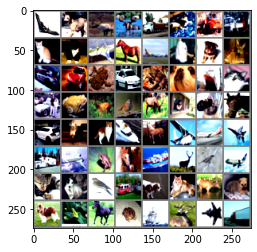

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [0]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, dropout=0.1):
        super(Net, self).__init__()
        self.dropout_val = dropout
        self.bias = False
        self.convblock1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=self.bias),nn.ReLU(),nn.BatchNorm2d(32), nn.Dropout(self.dropout_val)) 
        self.convblock2 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=self.bias),nn.ReLU(),nn.BatchNorm2d(32), nn.Dropout(self.dropout_val))
        self.convblock3 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(1, 1), padding=0, bias=self.bias)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.convblock4 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=self.bias),nn.ReLU(),nn.BatchNorm2d(64), nn.Dropout(self.dropout_val))
        self.convblock5 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, bias=self.bias),nn.ReLU(),nn.BatchNorm2d(64), nn.Dropout(self.dropout_val))
        self.convblock6 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1), padding=0, bias=self.bias)
        self.convblock7 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=self.bias),nn.ReLU(),nn.BatchNorm2d(128), nn.Dropout(self.dropout_val))
        self.convblock8 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, bias=self.bias),nn.ReLU(),nn.BatchNorm2d(128), nn.Dropout(self.dropout_val))
        self.convblock9 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1, bias=self.bias),nn.ReLU(),nn.BatchNorm2d(256), nn.Dropout(self.dropout_val))
        self.convblock10 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding=1, bias=self.bias),nn.ReLU(),nn.BatchNorm2d(256), nn.Dropout(self.dropout_val))
        self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=8)) # output_size = 1
        self.convblock11 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1, 1), padding=0, bias=self.bias)
        self.linear1 = nn.Linear(128,10)
        #self.conv6 = nn.Conv2d(32, 32, 3)
        #self.conv7 = nn.Conv2d(32, 10, 3)


    def forward(self, input):
      x1 = self.convblock3(input)
      x2 = self.convblock1(input) #input - 32; Output - 32; RF - 3; output channels - 32
      x3 = self.convblock2(x2+x1) #input - 32; Output - 32; RF - 5; output channels - 32
      x4 = self.pool1(x1+x2+x3) #input - 32; Output - 16; RF - 6; output channels - 32
      x5 = self.convblock4(x4)#input - 16; Output - 16; RF - 14; output channels - 64
      x41 = self.convblock6(x4)
      x6 = self.convblock5(x41+x5)#input - 16; Output - 16; RF - 18; output channels - 64
      x7 = self.convblock5(x41+x5+x6)#input - 16; Output - 16; RF - 22; output channels - 64
      x8 = self.pool1(x5+x6+x7)#input - 16; Output - 8; RF - 24; output channels - 64
      #x = self.convblock6(x)
      x81 = self.convblock11(x8)
      x9 = self.convblock7(x8)#input - 8; Output - 8; RF - 28; output channels - 128
      x10 = self.convblock8(x81+x9)#input - 8; Output - 8; RF - 36; output channels - 128
      x11 = self.convblock8(x81+x9+x10)
      #x = self.pool1(x) #input - 8; Output - 4; RF - 40; output channels - 10
      #x = self.convblock9(x) #input - 4; Output - 4; RF - 56; output channels - 10
      #x = self.convblock10(x)
      #x = self.convblock10(x)
      x12 = self.gap(x11)
      x12 = x12.view(-1, 128)
      x13 = self.linear1(x12)
      #x14 = x13.view(-1, 10)
      return F.log_softmax(x13)

In [36]:
model = Net(dropout=0.1).to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]              96
            Conv2d-2           [-1, 32, 32, 32]             864
              ReLU-3           [-1, 32, 32, 32]               0
       BatchNorm2d-4           [-1, 32, 32, 32]              64
           Dropout-5           [-1, 32, 32, 32]               0
            Conv2d-6           [-1, 32, 32, 32]           9,216
              ReLU-7           [-1, 32, 32, 32]               0
       BatchNorm2d-8           [-1, 32, 32, 32]              64
           Dropout-9           [-1, 32, 32, 32]               0
        MaxPool2d-10           [-1, 32, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]          18,432
             ReLU-12           [-1, 64, 16, 16]               0
      BatchNorm2d-13           [-1, 64, 16, 16]             128
          Dropout-14           [-1, 64,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [0]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch_number,l1_loss=False, l1_beta = 0):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    train_accuracy = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        train_accuracy += pred.eq(target.view_as(pred)).sum().item()
        loss = criterion(output, target)
        if l1_loss == True:
            l1_crit = nn.L1Loss(size_average=False)
            reg_loss = 0
            for param in model.parameters():
                target = torch.zeros_like(param)    
                reg_loss += l1_crit(param, target)
            loss += (l1_beta * reg_loss)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
        train_loss += loss.item()

    train_loss /= len(train_loader.dataset)
    train_accuracy = (100. * train_accuracy) / len(train_loader.dataset)
    return train_accuracy, train_loss

def test(model, device, test_loader, epoch_number):
    model.eval()
    test_loss = 0
    correct = 0
    example_images = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_accuracy = (100. * correct) / len(test_loader.dataset)
    return test_accuracy, test_loss

In [0]:
for epoch in range(1, 39):
        epoch_train_acc,epoch_train_loss = train(model, device, trainloader, optimizer, epoch)        
        epoch_test_acc,epoch_test_loss = test(model, device, testloader,epoch)

        print('\nEpoch: {:.0f} Train set: Average loss: {:.4f}, Accuracy: {:.3f}%'.format(epoch, epoch_train_loss, epoch_train_acc))
        print('Epoch: {:.0f} Test set: Average loss: {:.4f}, Accuracy: {:.3f}%'.format(epoch, epoch_test_loss, epoch_test_acc))
        # myoptim = optimizer.state_dict()['param_groups'][0]

        # print('Epoch: {:.0f} Optimizer values: LastLR:{:.10f}, Momentum: {:.10f}, Weight Decay: {:.10f}'.format(
        #  epoch, scheduler.get_last_lr()[0],myoptim['momentum'],myoptim['weight_decay']))
       
        # Baseline_Model_Metrics['Train Accuracy'].append(epoch_train_acc)
        # Baseline_Model_Metrics['Train Loss'].append(epoch_train_loss)
        # Baseline_Model_Metrics['Test Accuracy'].append(epoch_test_acc)
        # Baseline_Model_Metrics['Test Loss'].append(epoch_test_loss)
        # Baseline_Model_Metrics['Learning Rate'].append(config['lr'])
        # Baseline_Model_Metrics['Decay Learning Rate'].append(scheduler.get_lr()) 

        # if (epoch > config['start_lr']):
        #     scheduler.step()

  0%|          | 0/782 [00:00<?, ?it/s]


Epoch: 1 Train set: Average loss: 0.0246, Accuracy: 43.138%
Epoch: 1 Test set: Average loss: 0.0219, Accuracy: 48.990%


  0%|          | 0/782 [00:00<?, ?it/s]


Epoch: 2 Train set: Average loss: 0.0189, Accuracy: 56.854%
Epoch: 2 Test set: Average loss: 0.0178, Accuracy: 59.470%


  0%|          | 0/782 [00:00<?, ?it/s]


Epoch: 3 Train set: Average loss: 0.0163, Accuracy: 62.986%
Epoch: 3 Test set: Average loss: 0.0153, Accuracy: 64.900%


  0%|          | 0/782 [00:00<?, ?it/s]


Epoch: 4 Train set: Average loss: 0.0145, Accuracy: 67.340%
Epoch: 4 Test set: Average loss: 0.0147, Accuracy: 66.860%


  0%|          | 0/782 [00:00<?, ?it/s]


Epoch: 5 Train set: Average loss: 0.0132, Accuracy: 70.182%
Epoch: 5 Test set: Average loss: 0.0136, Accuracy: 69.260%


  0%|          | 0/782 [00:00<?, ?it/s]


Epoch: 6 Train set: Average loss: 0.0122, Accuracy: 72.584%
Epoch: 6 Test set: Average loss: 0.0129, Accuracy: 71.010%


  0%|          | 0/782 [00:00<?, ?it/s]


Epoch: 7 Train set: Average loss: 0.0113, Accuracy: 74.820%
Epoch: 7 Test set: Average loss: 0.0116, Accuracy: 74.120%


  0%|          | 0/782 [00:00<?, ?it/s]


Epoch: 8 Train set: Average loss: 0.0104, Accuracy: 76.878%
Epoch: 8 Test set: Average loss: 0.0110, Accuracy: 75.630%


  0%|          | 0/782 [00:00<?, ?it/s]


Epoch: 9 Train set: Average loss: 0.0097, Accuracy: 78.360%
Epoch: 9 Test set: Average loss: 0.0110, Accuracy: 75.290%


  0%|          | 0/782 [00:00<?, ?it/s]


Epoch: 10 Train set: Average loss: 0.0091, Accuracy: 79.832%
Epoch: 10 Test set: Average loss: 0.0102, Accuracy: 77.460%


  0%|          | 0/782 [00:00<?, ?it/s]


Epoch: 11 Train set: Average loss: 0.0086, Accuracy: 81.074%
Epoch: 11 Test set: Average loss: 0.0103, Accuracy: 76.770%


  0%|          | 0/782 [00:00<?, ?it/s]


Epoch: 12 Train set: Average loss: 0.0081, Accuracy: 81.854%
Epoch: 12 Test set: Average loss: 0.0092, Accuracy: 79.730%


  0%|          | 0/782 [00:00<?, ?it/s]


Epoch: 13 Train set: Average loss: 0.0077, Accuracy: 82.864%
Epoch: 13 Test set: Average loss: 0.0095, Accuracy: 78.970%


  0%|          | 0/782 [00:00<?, ?it/s]


Epoch: 14 Train set: Average loss: 0.0073, Accuracy: 83.942%
Epoch: 14 Test set: Average loss: 0.0095, Accuracy: 79.980%


  0%|          | 0/782 [00:00<?, ?it/s]


Epoch: 15 Train set: Average loss: 0.0069, Accuracy: 84.638%
Epoch: 15 Test set: Average loss: 0.0095, Accuracy: 79.420%


  0%|          | 0/782 [00:00<?, ?it/s]


Epoch: 16 Train set: Average loss: 0.0066, Accuracy: 85.432%
Epoch: 16 Test set: Average loss: 0.0089, Accuracy: 80.960%


  0%|          | 0/782 [00:00<?, ?it/s]


Epoch: 17 Train set: Average loss: 0.0063, Accuracy: 86.154%
Epoch: 17 Test set: Average loss: 0.0088, Accuracy: 81.670%


  0%|          | 0/782 [00:00<?, ?it/s]


Epoch: 18 Train set: Average loss: 0.0060, Accuracy: 86.632%
Epoch: 18 Test set: Average loss: 0.0094, Accuracy: 80.350%


  0%|          | 0/782 [00:00<?, ?it/s]


Epoch: 19 Train set: Average loss: 0.0058, Accuracy: 87.236%
Epoch: 19 Test set: Average loss: 0.0092, Accuracy: 81.160%


  0%|          | 0/782 [00:00<?, ?it/s]


Epoch: 20 Train set: Average loss: 0.0055, Accuracy: 87.820%
Epoch: 20 Test set: Average loss: 0.0088, Accuracy: 81.610%


  0%|          | 0/782 [00:00<?, ?it/s]


Epoch: 21 Train set: Average loss: 0.0052, Accuracy: 88.476%
Epoch: 21 Test set: Average loss: 0.0089, Accuracy: 81.670%


  0%|          | 0/782 [00:00<?, ?it/s]


Epoch: 22 Train set: Average loss: 0.0051, Accuracy: 88.676%
Epoch: 22 Test set: Average loss: 0.0092, Accuracy: 81.090%


  0%|          | 0/782 [00:00<?, ?it/s]


Epoch: 23 Train set: Average loss: 0.0048, Accuracy: 89.398%
Epoch: 23 Test set: Average loss: 0.0089, Accuracy: 82.080%


  0%|          | 0/782 [00:00<?, ?it/s]


Epoch: 24 Train set: Average loss: 0.0046, Accuracy: 89.806%
Epoch: 24 Test set: Average loss: 0.0093, Accuracy: 81.770%


  0%|          | 0/782 [00:00<?, ?it/s]


Epoch: 25 Train set: Average loss: 0.0044, Accuracy: 90.050%
Epoch: 25 Test set: Average loss: 0.0086, Accuracy: 82.770%


  0%|          | 0/782 [00:00<?, ?it/s]


Epoch: 26 Train set: Average loss: 0.0043, Accuracy: 90.640%
Epoch: 26 Test set: Average loss: 0.0089, Accuracy: 82.410%


  0%|          | 0/782 [00:00<?, ?it/s]


Epoch: 27 Train set: Average loss: 0.0041, Accuracy: 91.144%
Epoch: 27 Test set: Average loss: 0.0091, Accuracy: 82.610%


  0%|          | 0/782 [00:00<?, ?it/s]


Epoch: 28 Train set: Average loss: 0.0039, Accuracy: 91.240%
Epoch: 28 Test set: Average loss: 0.0089, Accuracy: 82.270%


  0%|          | 0/782 [00:00<?, ?it/s]


Epoch: 29 Train set: Average loss: 0.0037, Accuracy: 91.878%
Epoch: 29 Test set: Average loss: 0.0090, Accuracy: 82.910%


  0%|          | 0/782 [00:00<?, ?it/s]


Epoch: 30 Train set: Average loss: 0.0036, Accuracy: 92.212%
Epoch: 30 Test set: Average loss: 0.0093, Accuracy: 82.530%


  0%|          | 0/782 [00:00<?, ?it/s]


Epoch: 31 Train set: Average loss: 0.0034, Accuracy: 92.528%
Epoch: 31 Test set: Average loss: 0.0090, Accuracy: 83.060%


  0%|          | 0/782 [00:00<?, ?it/s]


Epoch: 32 Train set: Average loss: 0.0034, Accuracy: 92.572%
Epoch: 32 Test set: Average loss: 0.0089, Accuracy: 83.140%


  0%|          | 0/782 [00:00<?, ?it/s]


Epoch: 33 Train set: Average loss: 0.0032, Accuracy: 92.976%
Epoch: 33 Test set: Average loss: 0.0095, Accuracy: 82.410%


  0%|          | 0/782 [00:00<?, ?it/s]


Epoch: 34 Train set: Average loss: 0.0031, Accuracy: 93.126%
Epoch: 34 Test set: Average loss: 0.0088, Accuracy: 83.180%


  0%|          | 0/782 [00:00<?, ?it/s]


Epoch: 35 Train set: Average loss: 0.0029, Accuracy: 93.664%
Epoch: 35 Test set: Average loss: 0.0096, Accuracy: 82.230%


loss=0.12713828682899475 batch_id=52:   6%|▋         | 50/782 [00:01<00:17, 42.36it/s]

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [0]:
outputs = model(images.to(device))

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [0]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images.to(device)).to("cpu")
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images.to(device)).to('cpu')
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))